The project is about using supervised ML algorithm to perform regression on the popular California census data to predict the median housing prices of each block group in California while following the machine learning project checklist provided by the book. The dataset was modified by the author for teaching purposes.

In [2]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

In [3]:
# Function to load the modified data from author's github to a pandas dataframe
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")

    if not tarball_path.is_file():
        Path("datasets").mkdir(exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

#load data
housing = load_housing_data()

In [4]:
housing.head() # see first five rows of dataset

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing["ocean_proximity"].value_counts() # check unique values of "ocean_proximity" column

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


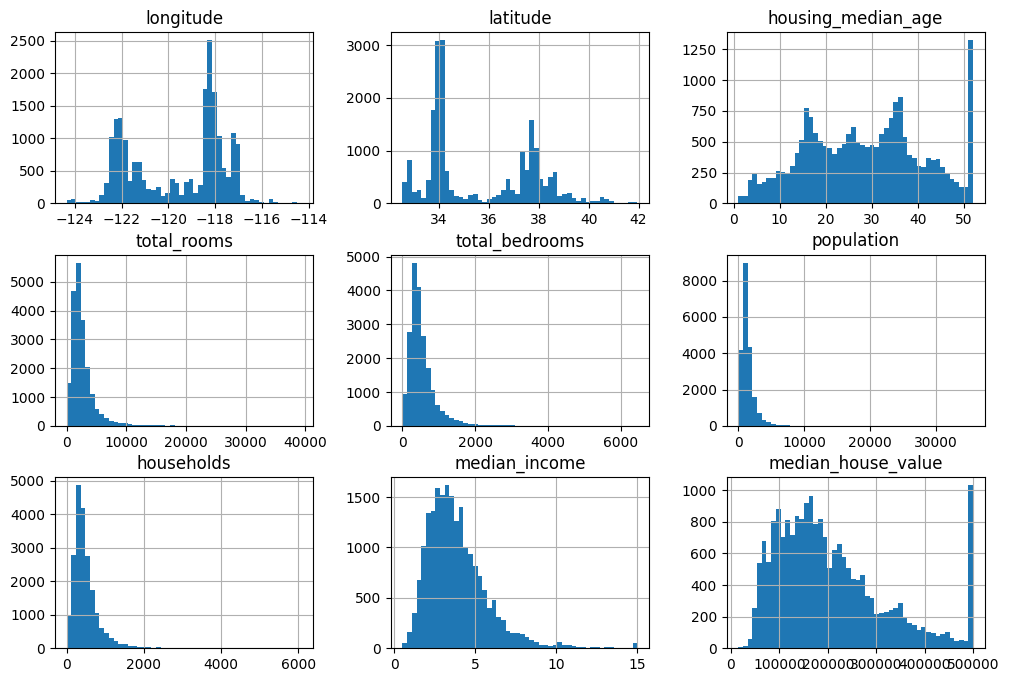

In [8]:
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(12,8))
plt.show()

In [9]:
# create a function for splitting data into training set and test set
# and picking samples randomly
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
print(len(train_set))
print(len(test_set))


16512
4128


In [11]:
# since shuffle_and_split_data is not consistent if the dataset is increased in size
# the following function should fix this problem
"""For example, you could compute a hash of each
instance’s identifier and put that instance in the test set if the hash is lower
than or equal to 20% of the maximum hash value. This ensures that the test
set will remain consistent across multiple runs, even if you refresh the
dataset. The new test set will contain 20% of the new instances, but it will
not contain any instance that was previously in the training set."""

from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [12]:
housing_with_id = housing.reset_index() # adds  an 'index' column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, 'index')
print(len(train_set), len(test_set))

16512 4128


In [13]:
 # anohter way of creating an identifier column
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, 'id')
print(len(train_set), len(test_set))

16322 4318


In [14]:
# scikit learn dataset splitting implementation
"""Scikit-Learn provides a few functions to split datasets into multiple subsets
in various ways. The simplest function is train_test_split(), which
does pretty much the same thing as the shuffle_and_split_data()
function we defined earlier, with a couple of additional features. First, there
is a random_state parameter that allows you to set the random generator
seed. Second, you can pass it multiple datasets with an identical number of
rows, and it will split them on the same indices"""

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [15]:
# Create an income category attribute with 5 categories for stratified sampling
housing["income_cat"] = pd.cut(housing['median_income'], bins=[0,1.5,3,4.5,6,np.inf], labels=[1,2,3,4,5])

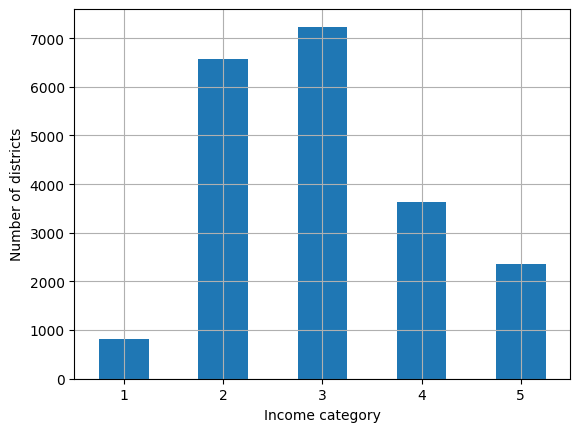

In [16]:
# income_cat representation
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [17]:
# generate 10 stratified splits of the same(housing) dataset
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2,random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing['income_cat']):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_train_set_n])

In [18]:
strat_train_set, strat_test_set = strat_splits[0] # get a single split
# or use train_test_split with stratify = housing["income_cat"]
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [19]:
# see proportions
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [20]:
# compare imcome category proportions inthe overall dataset,
# test set with stratified sampling, and test set with random sampling
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({"Overall %": income_cat_proportions(housing),
                              "Stratified %": income_cat_proportions(strat_test_set),
                              "Random %": income_cat_proportions(test_set),
                             }).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = compare_props["Stratified %"] / compare_props["Overall %"] - 1
compare_props["Rand. Error %"] = compare_props["Random %"] / compare_props["Overall %"] - 1

(compare_props * 100).round(2)
# random sampling creates a skewed test set

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


In [21]:
# reverting data back to original state now that we have stratified datasets
# dropping income_cat column
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1,inplace=True)

In [23]:
# making a copy of the training set so I can revert to it afterwards
housing = strat_train_set.copy()

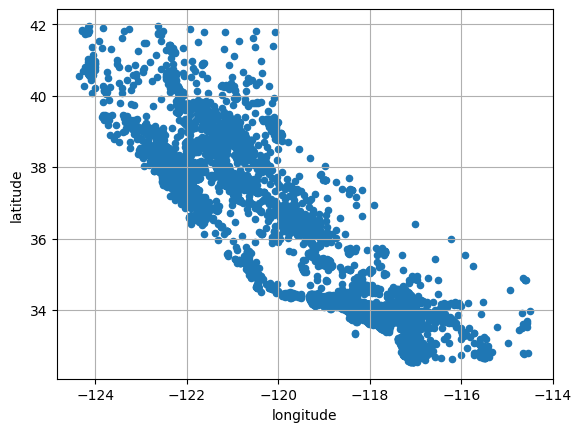

In [24]:
# visualize longitude and latitude 
housing.plot(kind="scatter",x='longitude', y="latitude", grid=True)
plt.show()

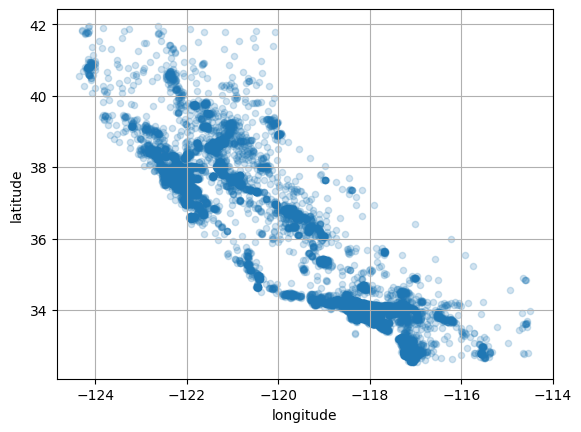

In [26]:
# visualize longitude and latitude on a smaller alpha
housing.plot(kind="scatter",x="longitude",y="latitude",grid=True, alpha=0.2)
plt.show()

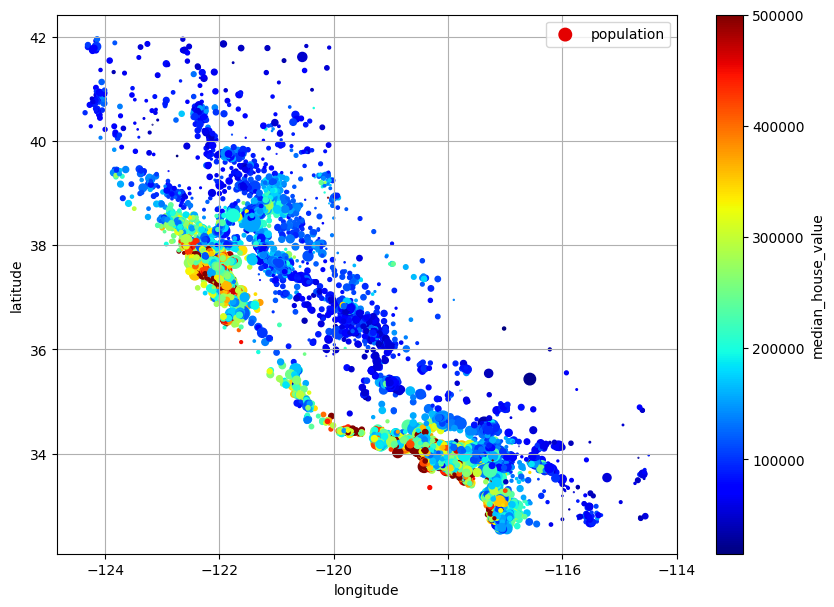

In [39]:
# scatter plot of longitude and latitude with population and housing prices
# option s is population (influences the radius)
# option c is the housing prices which influences the color ranging from
# blue (low price) to red (high price)
housing.plot(kind="scatter", x="longitude",y="latitude",grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, figsize=(10,7))
plt.show()